In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import joblib
from gas_forecaster import ModelForecaster

#forecaster = gas_forecaster.ModelForecaster

with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load (f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

"""train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']"""

min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df


Neuste Änderung: prints


### untuned

MAE: 1.5394
RMSE: 2.0704
R²: 0.8870


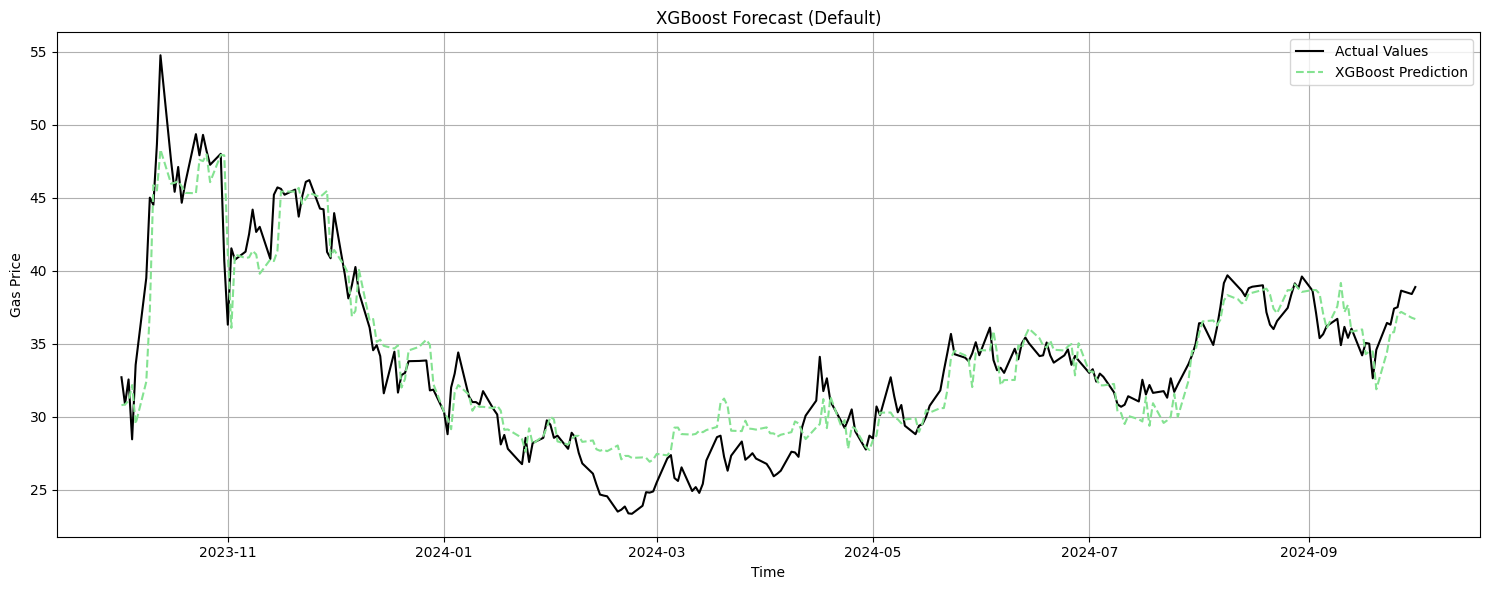

In [2]:
# Feature-Auswahl
selected_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7',
                     'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1',
                     'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30',
                     'P-European_News_Index_lag1', 'P-GPR_lag1',
                     'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

# Daten vorbereiten
X_train = train_df[selected_features]
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features]
y_test = test_y_df.values.ravel()

# XGBoost mit Standardparametern
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)

# Rückskalierung
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_test_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='XGBoost Prediction', linestyle='--', color='#84E291')
plt.title('XGBoost Forecast (Default)')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Including gas price and Grid Search


Fitting 4 folds for each of 1 candidates, totalling 4 fits

Beste Hyperparameter: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.9}
MAE auf Holdout-Set: 2.3543
0.00849144160747528
RMSE auf Holdout-Set: 3.0064
R^2 auf Holdout-Set: 0.7617


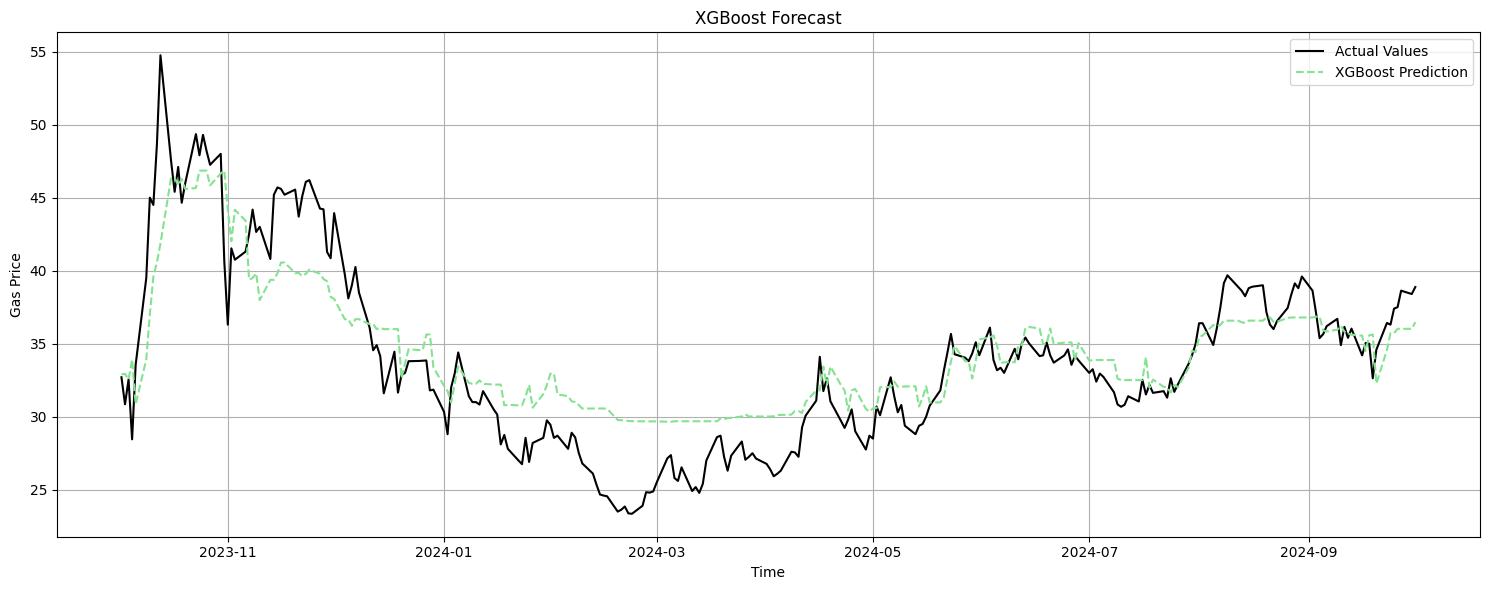

In [2]:
# Zeitreihen-CV definieren
tscv = TimeSeriesSplit(n_splits=4)

# Feature Selection mit SFS und XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror')

selected_features = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']
# Grid für Hyperparameter-Optimierung
"""param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [ 0.01, 0.1, 0.3],
    'reg_lambda': [1, 0.1, 0.03],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}"""
#Grid mti besten Parametern 
param_grid = {
    'colsample_bytree': [0.9],
    'gamma': [0],
    'learning_rate': [0.01],
    'max_depth': [3],
    'min_child_weight': [1],
    'n_estimators': [400],
    'reg_alpha': [0.01],
    'reg_lambda': [0.03],
    'subsample': [0.9]
}

X_train_sel = train_df[selected_features]
X_test_sel = test_df[selected_features]

grid_search = GridSearchCV(
    XGBRegressor(objective='reg:squarederror'),
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sel, train_y_df)

# Bestes Modell und Vorhersage
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sel)

### Ohne Differenzierung
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
test_y_array = test_y_df.values
# Rückskalierung der echten Werte für das Holdout-Set
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_array.reshape(-1, 1)).flatten()
# MAE berechnen
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
mae_without = mean_absolute_error (test_y_df, y_pred)
print(f"\nBeste Hyperparameter: {grid_search.best_params_}")
print(f"MAE auf Holdout-Set: {mae:.4f}")
print (mae_without)

rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
print(f"RMSE auf Holdout-Set: {rmse:.4f}")
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)
print (f"R^2 auf Holdout-Set: {r2:.4f}")

# Plot

plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='XGBoost Prediction', linestyle='--', color='#84E291')
plt.title('XGBoost Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
mask = (
    (train_df['Season_Summer'] == 1) &
    (train_df['K-Temperatur 2m'] > 0.9) &
    (train_df['K-Temperatur 2m_rollmax_7'] > 0.9)
)
print(mask.sum())  # Wie oft?

27


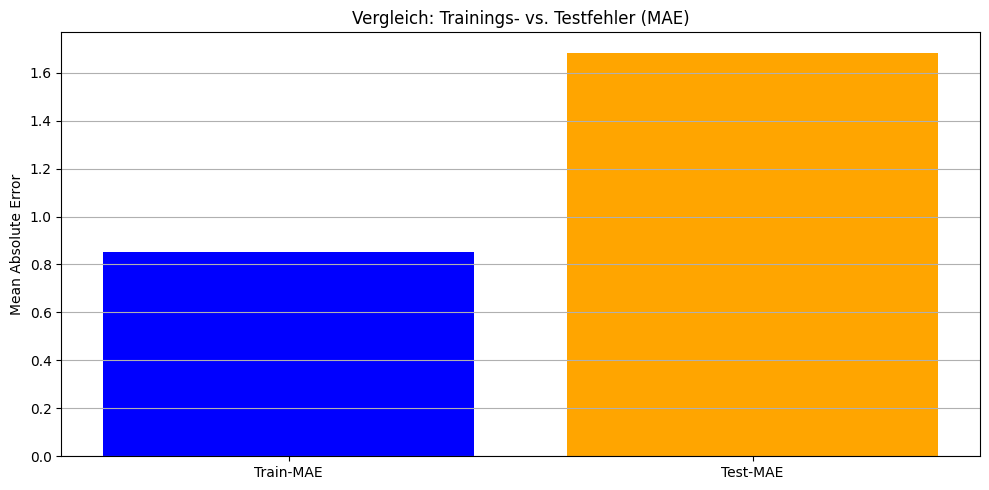

In [3]:
# --- Trainingsfehler berechnen ---
y_train_pred_scaled = best_model.predict(X_train_sel)
y_train_pred_rescaled = y_min_max_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_rescaled = y_min_max_scaler.inverse_transform(train_y_df.values.reshape(-1, 1)).flatten()

train_mae = mean_absolute_error(y_train_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)

# --- Fehlerverlauf visualisieren ---
plt.figure(figsize=(10, 5))
plt.bar(['Train-MAE', 'Test-MAE'], [train_mae, test_mae], color=['blue', 'orange'])
plt.title('Vergleich: Trainings- vs. Testfehler (MAE)')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



CV-bestes MAE: 0.0484
Test-MAE: 1.8196


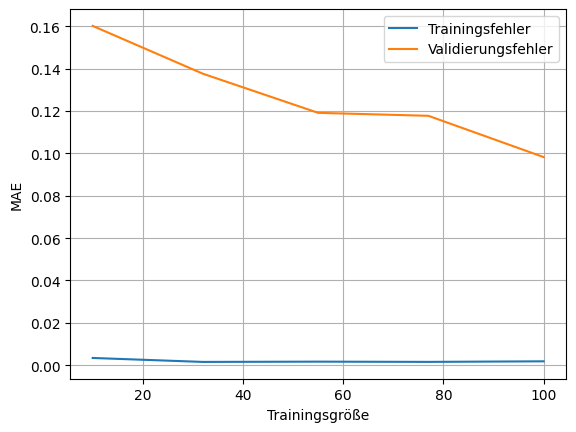

In [19]:
cv_results = grid_search.cv_results_
print(f"CV-bestes MAE: {-grid_search.best_score_:.4f}")  # neg. MAE → negativ aufheben

# Testfehler bereits berechnet:
print(f"Test-MAE: {mae:.4f}")

from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_sel, train_y_df.values.ravel(),
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1
)

train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_errors, label='Trainingsfehler')
plt.plot(train_sizes, val_errors, label='Validierungsfehler')
plt.xlabel('Trainingsgröße')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
model_filename = 'xgboost_2305.pkl'

# Speichern des Modells
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nBestes Modell wurde unter '{model_filename}' gespeichert.")


Bestes Modell wurde unter 'xgboost_2305.pkl' gespeichert.


### without gas price and GridSearch

MAE (rescaled): 29.2044
MAE (unscaled): 0.1053
RMSE (rescaled): 31.9014
R² (rescaled): -25.8352


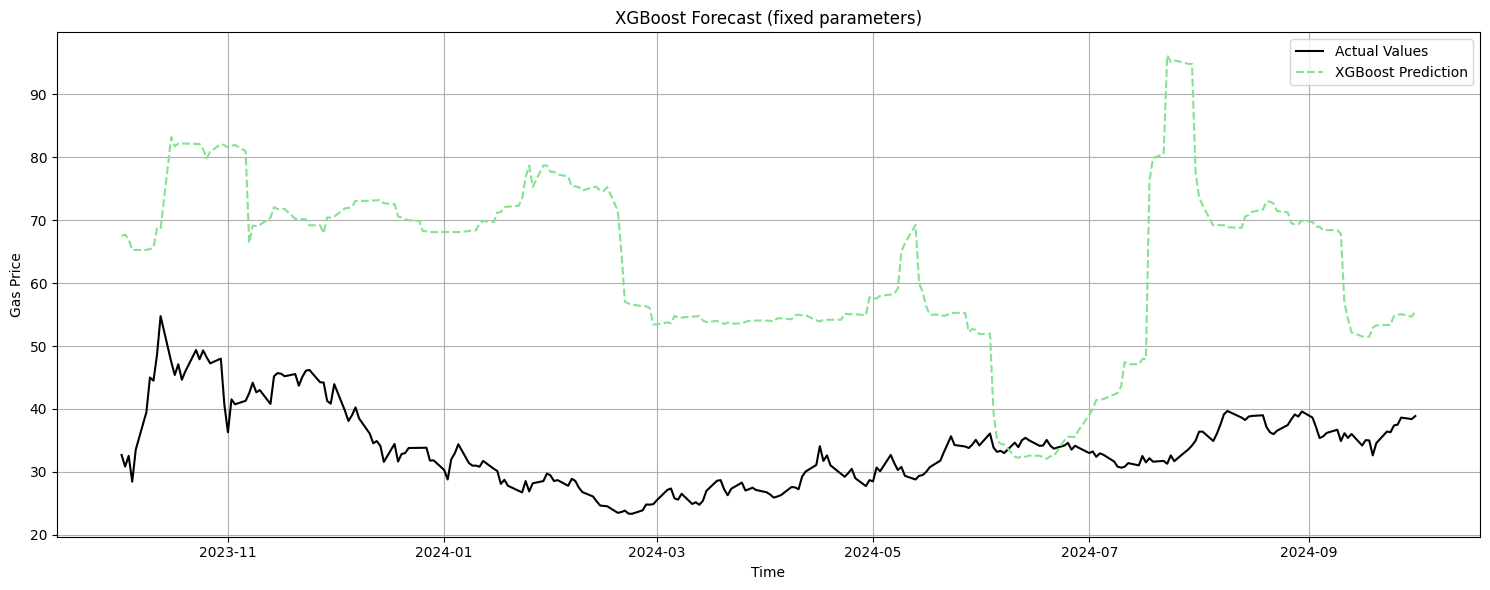

In [30]:
# Direktes Training mit gewählten Parametern (ohne GridSearch)
model = XGBRegressor(
    objective='reg:squarederror',
    **grid_search.best_params_
)

selected_features = ['N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

X_train_sel = train_df[selected_features]
X_test_sel = test_df[selected_features]

model.fit(X_train_sel, train_y_df)
y_pred = model.predict(X_test_sel)

# Rückskalierung
y_pred_rescaled = y_min_max_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
mae_without = mean_absolute_error(test_y_df, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred_rescaled))
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"MAE (rescaled): {mae:.4f}")
print(f"MAE (unscaled): {mae_without:.4f}")
print(f"RMSE (rescaled): {rmse:.4f}")
print(f"R² (rescaled): {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred_rescaled, label='XGBoost Prediction', linestyle='--', color='#84E291')
plt.title('XGBoost Forecast (fixed parameters)')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SHAP und FI

In [4]:

#xgb = best_model  
# for without gas price
xgb = best_model

In [5]:
import shap
# SHAP-Werte berechnen
explainer = shap.TreeExplainer(xgb)
shap_values_train = explainer.shap_values(X_train_sel)
shap_values_test = explainer.shap_values(X_test_sel)

c:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Python 3.12\venvMasterarbeit\Lib\site-packages\slicer\slicer.py:6: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  from .slicer_internal import AtomicSlicer, Alias, Obj, AliasLookup, Tracked, UnifiedDataHandler
c:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Python 3.12\venvMasterarbeit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Feature Importance:
                             features  importance
9     S-Coal Price (close)_rollmean_7    0.325429
3           S-Coal Price (close)_lag1    0.309298
0            N-Demand LDZ_rollmean_30    0.114267
6             N-Demand LDZ_rollstd_30    0.070226
10     S-Coal Price (close)_rollstd_3    0.043031
7          P-European_News_Index_lag1    0.039180
2   P-European_News_Index_rollmean_30    0.032175
8                          P-GPR_lag1    0.030485
5                   P-GPR_rollmean_30    0.029184
1             K-Wind speed_rollmean_7    0.006725
4                       Season_Winter    0.000000
                              Feature  MeanAbsSHAP
3           S-Coal Price (close)_lag1     0.084221
0            N-Demand LDZ_rollmean_30     0.038778
9     S-Coal Price (close)_rollmean_7     0.032105
8                          P-GPR_lag1     0.021094
5                   P-GPR_rollmean_30     0.014592
2   P-European_News_Index_rollmean_30     0.011679
10     S-Coal Price (c

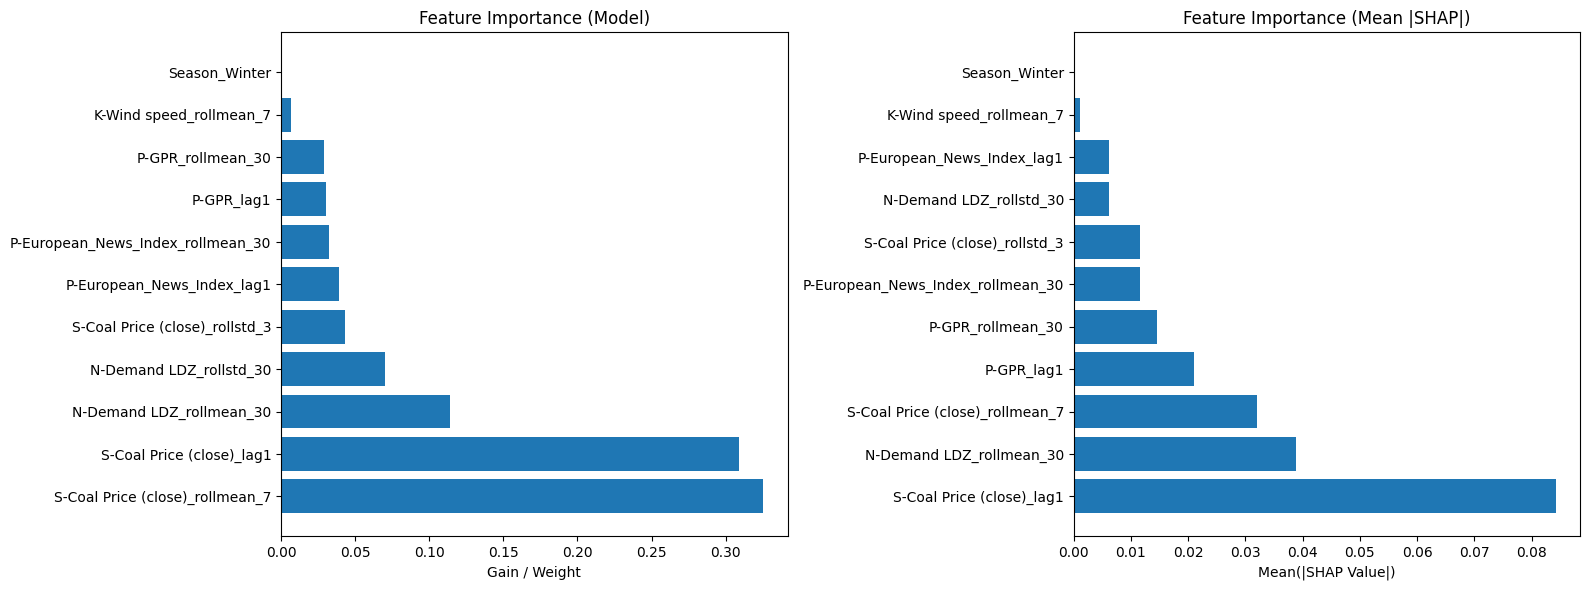

In [34]:
# Wichtigkeit der Features aus dem Modell extrahieren (aus Modell direkt)
importance = pd.concat([
    pd.DataFrame(selected_features, columns=["features"]),
    pd.DataFrame(np.transpose(xgb.feature_importances_), columns=["importance"])
], axis=1)
importance = importance.sort_values(by="importance", ascending=False)
print("\nFeature Importance:")
print(importance)

mean_abs_shap_train = np.abs(shap_values_train).mean(axis=0)

# Zu DataFrame mit Spaltennamen aus den Trainingsdaten
shap_importance_train = pd.DataFrame({
    "Feature": selected_features,
    "MeanAbsSHAP": mean_abs_shap_train
}).sort_values(by="MeanAbsSHAP", ascending=False)

# Ausgabe
print(shap_importance_train)
# Zwei Balkendiagramme nebeneinander: Modellimportance vs. SHAP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot: Feature Importance aus dem Modell
axes[0].barh(importance["features"][::-1], importance["importance"][::-1])
axes[0].set_title("Feature Importance (Model)")
axes[0].set_xlabel("Gain / Weight")
axes[0].invert_yaxis()

# Plot: SHAP Importance
axes[1].barh(shap_importance_train["Feature"][::-1], shap_importance_train["MeanAbsSHAP"][::-1])
axes[1].set_title("Feature Importance (Mean |SHAP|)")
axes[1].set_xlabel("Mean(|SHAP Value|)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

SHAP-Waterfall: Sample 0


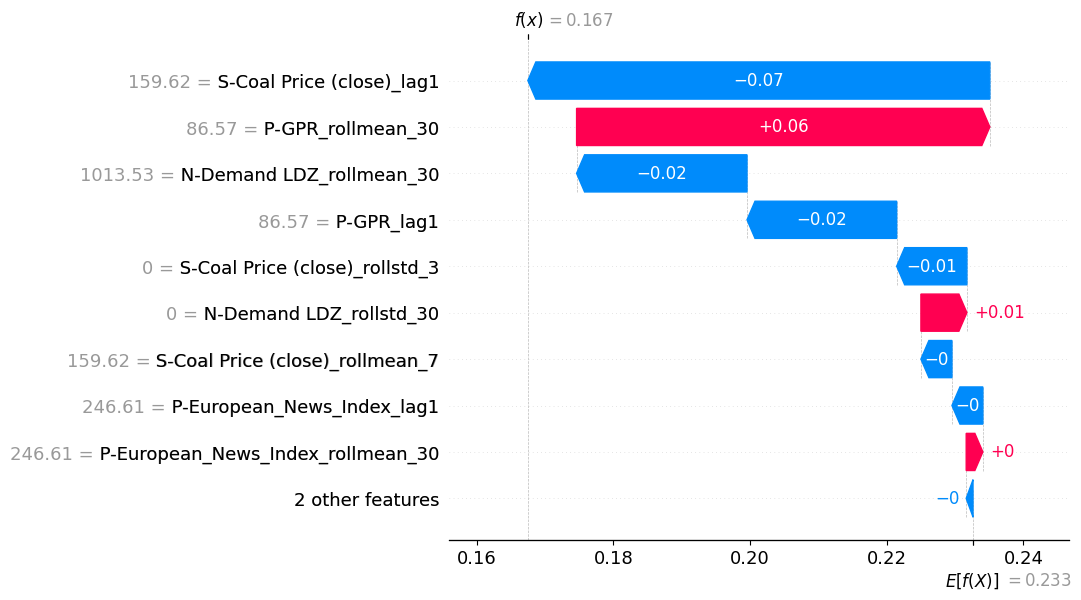

SHAP-Waterfall: Sample 60


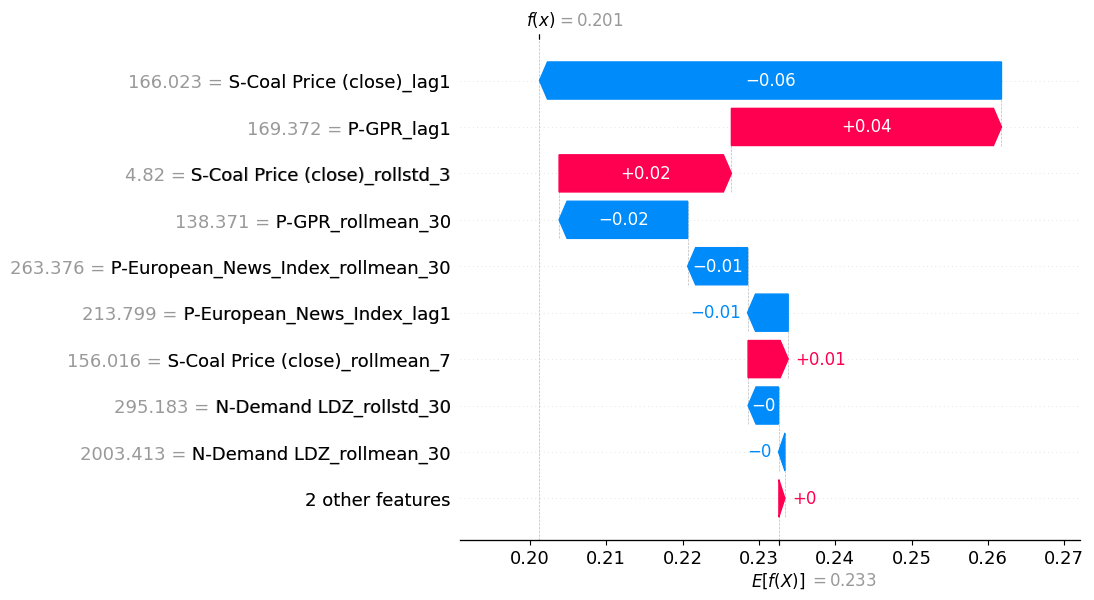

SHAP-Waterfall: Sample 120


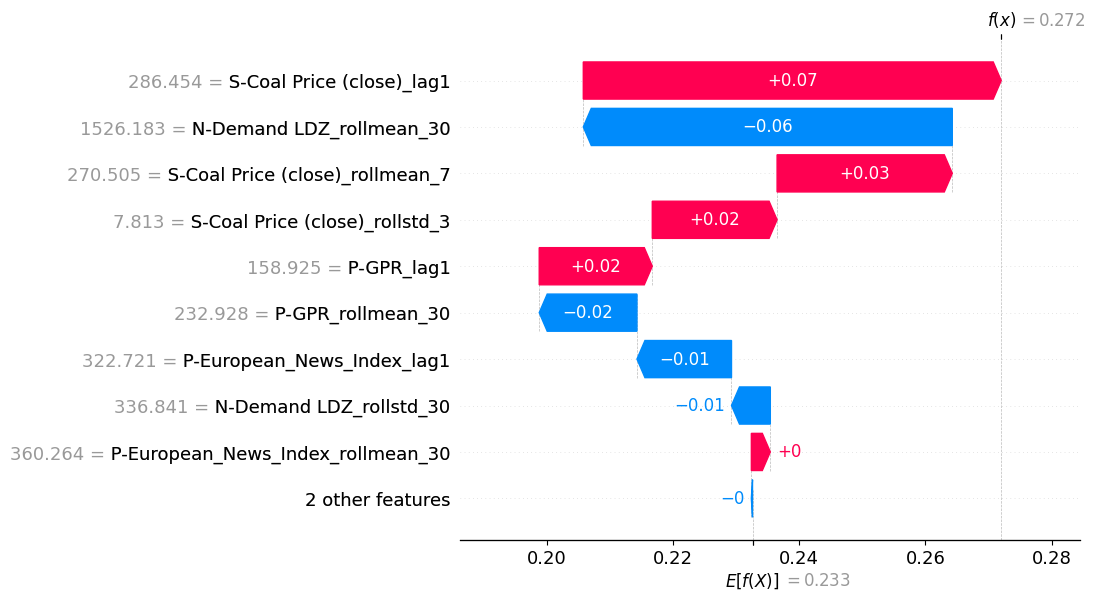

SHAP-Waterfall: Sample 180


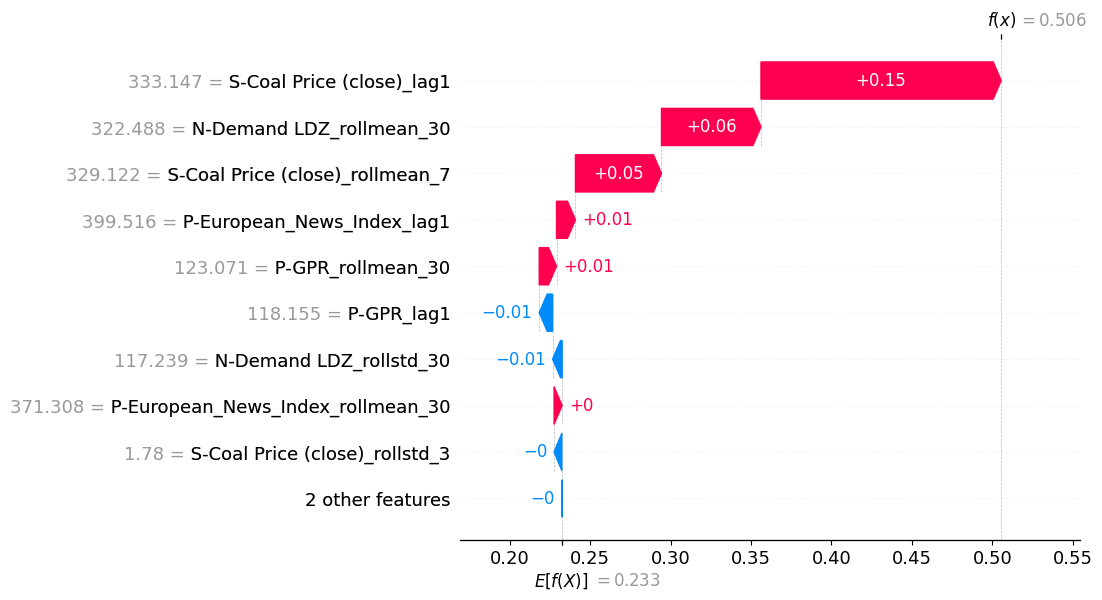

SHAP-Waterfall: Sample 240


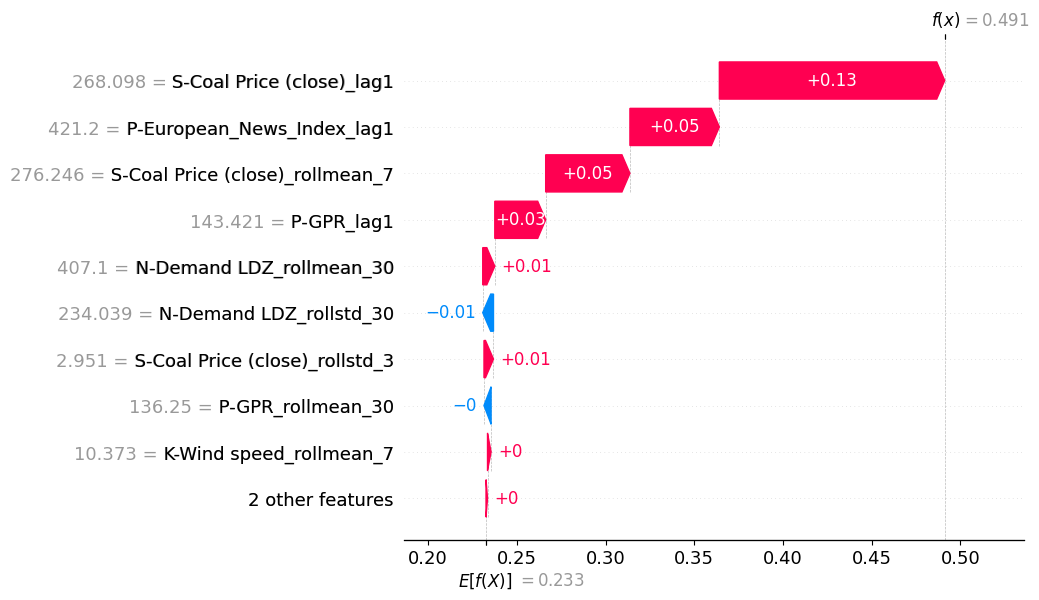

SHAP-Waterfall: Sample 300


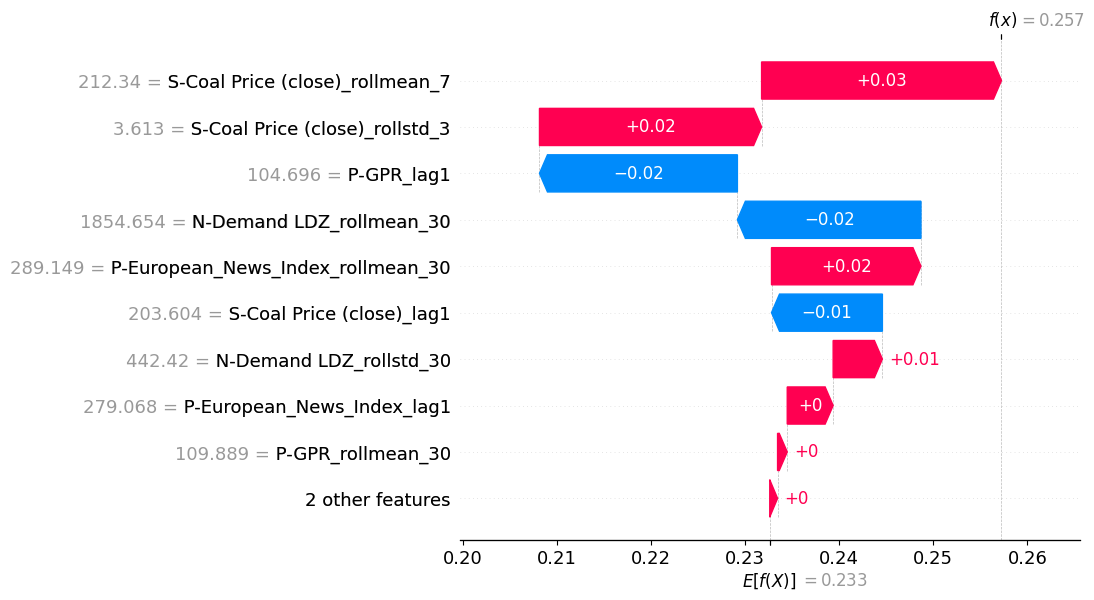

SHAP-Waterfall: Sample 360


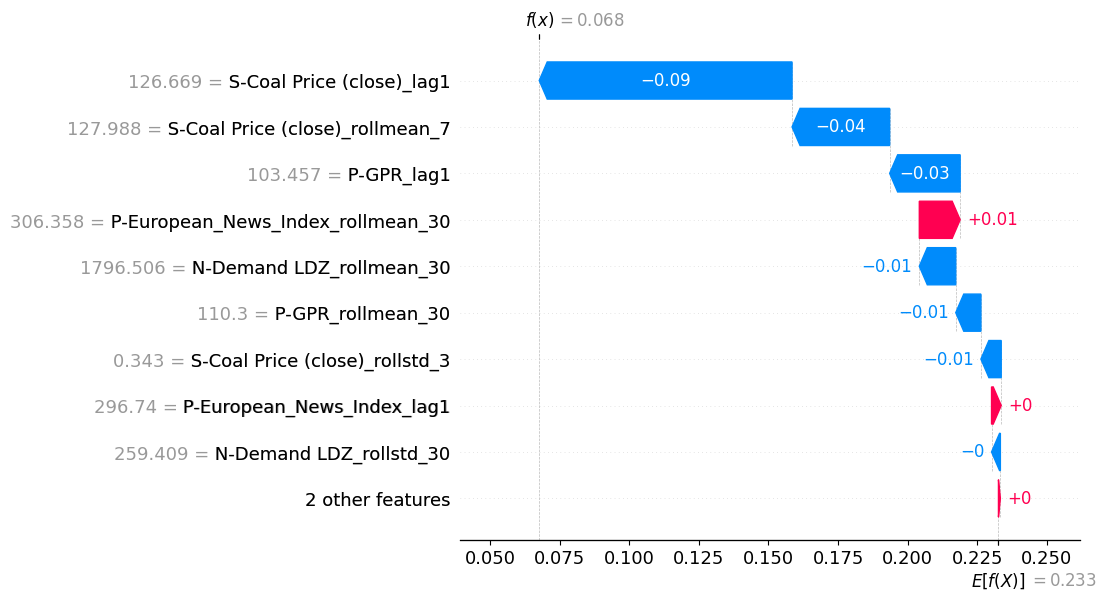

SHAP-Waterfall: Sample 420


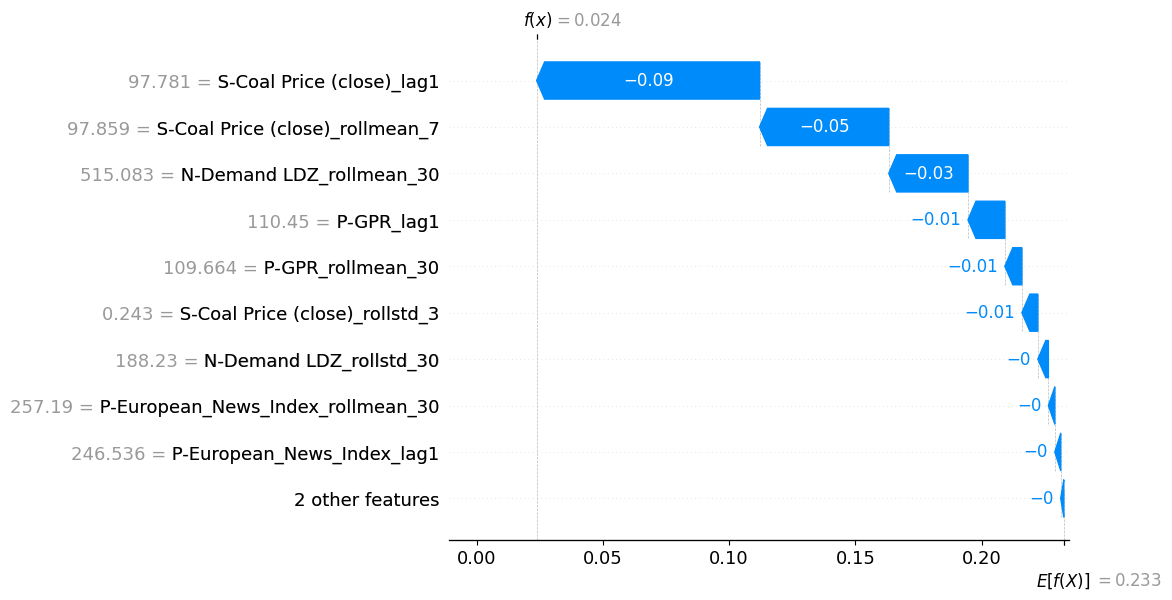

SHAP-Waterfall: Sample 480


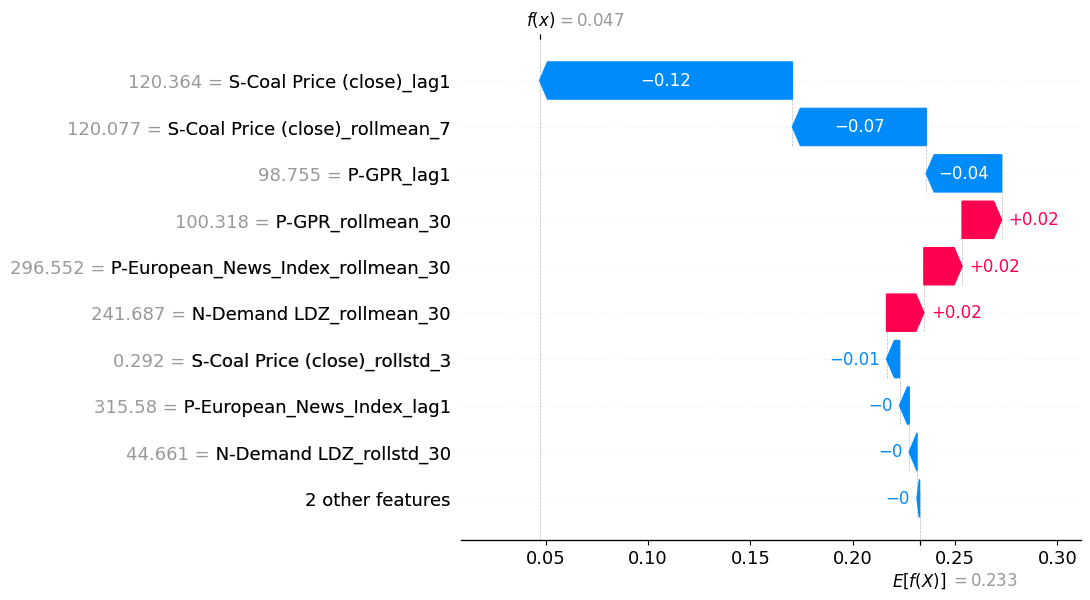

In [35]:
with open('unscaled_train_final_df.pkl', 'rb') as f:
    unscaled_train_final_df = pickle.load(f)

# 2. Features einschränken
x_train_unscaled_shap = unscaled_train_final_df[selected_features]

# 3. Indizes auswählen (jede 60. Instanz)
indices = list(range(0, len(x_train_unscaled_shap), 60))

# 4. Plots untereinander anzeigen
for i in indices:
    print(f"SHAP-Waterfall: Sample {i}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_train[i],
            base_values=explainer.expected_value,
            data=x_train_unscaled_shap.iloc[i],
            feature_names=x_train_unscaled_shap.columns
        )
    )


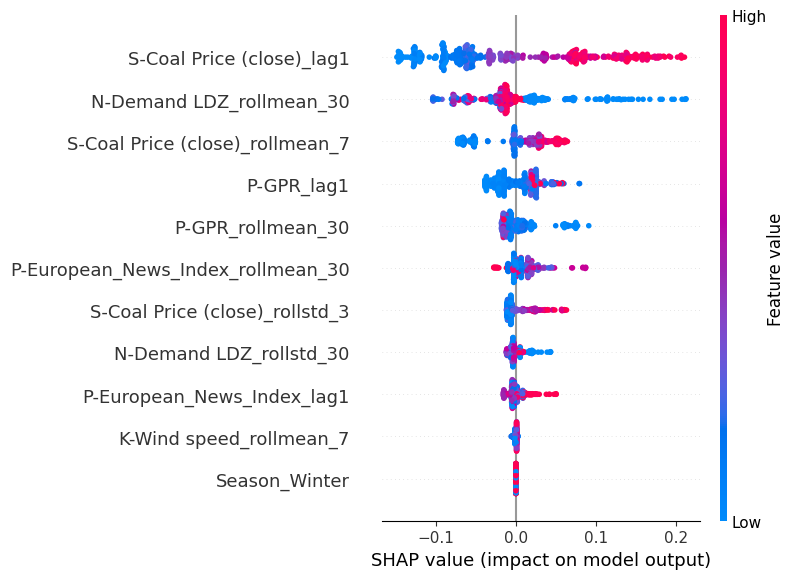

In [36]:
# SHAP Summary Plot
shap.summary_plot(shap_values_train, X_train_sel)


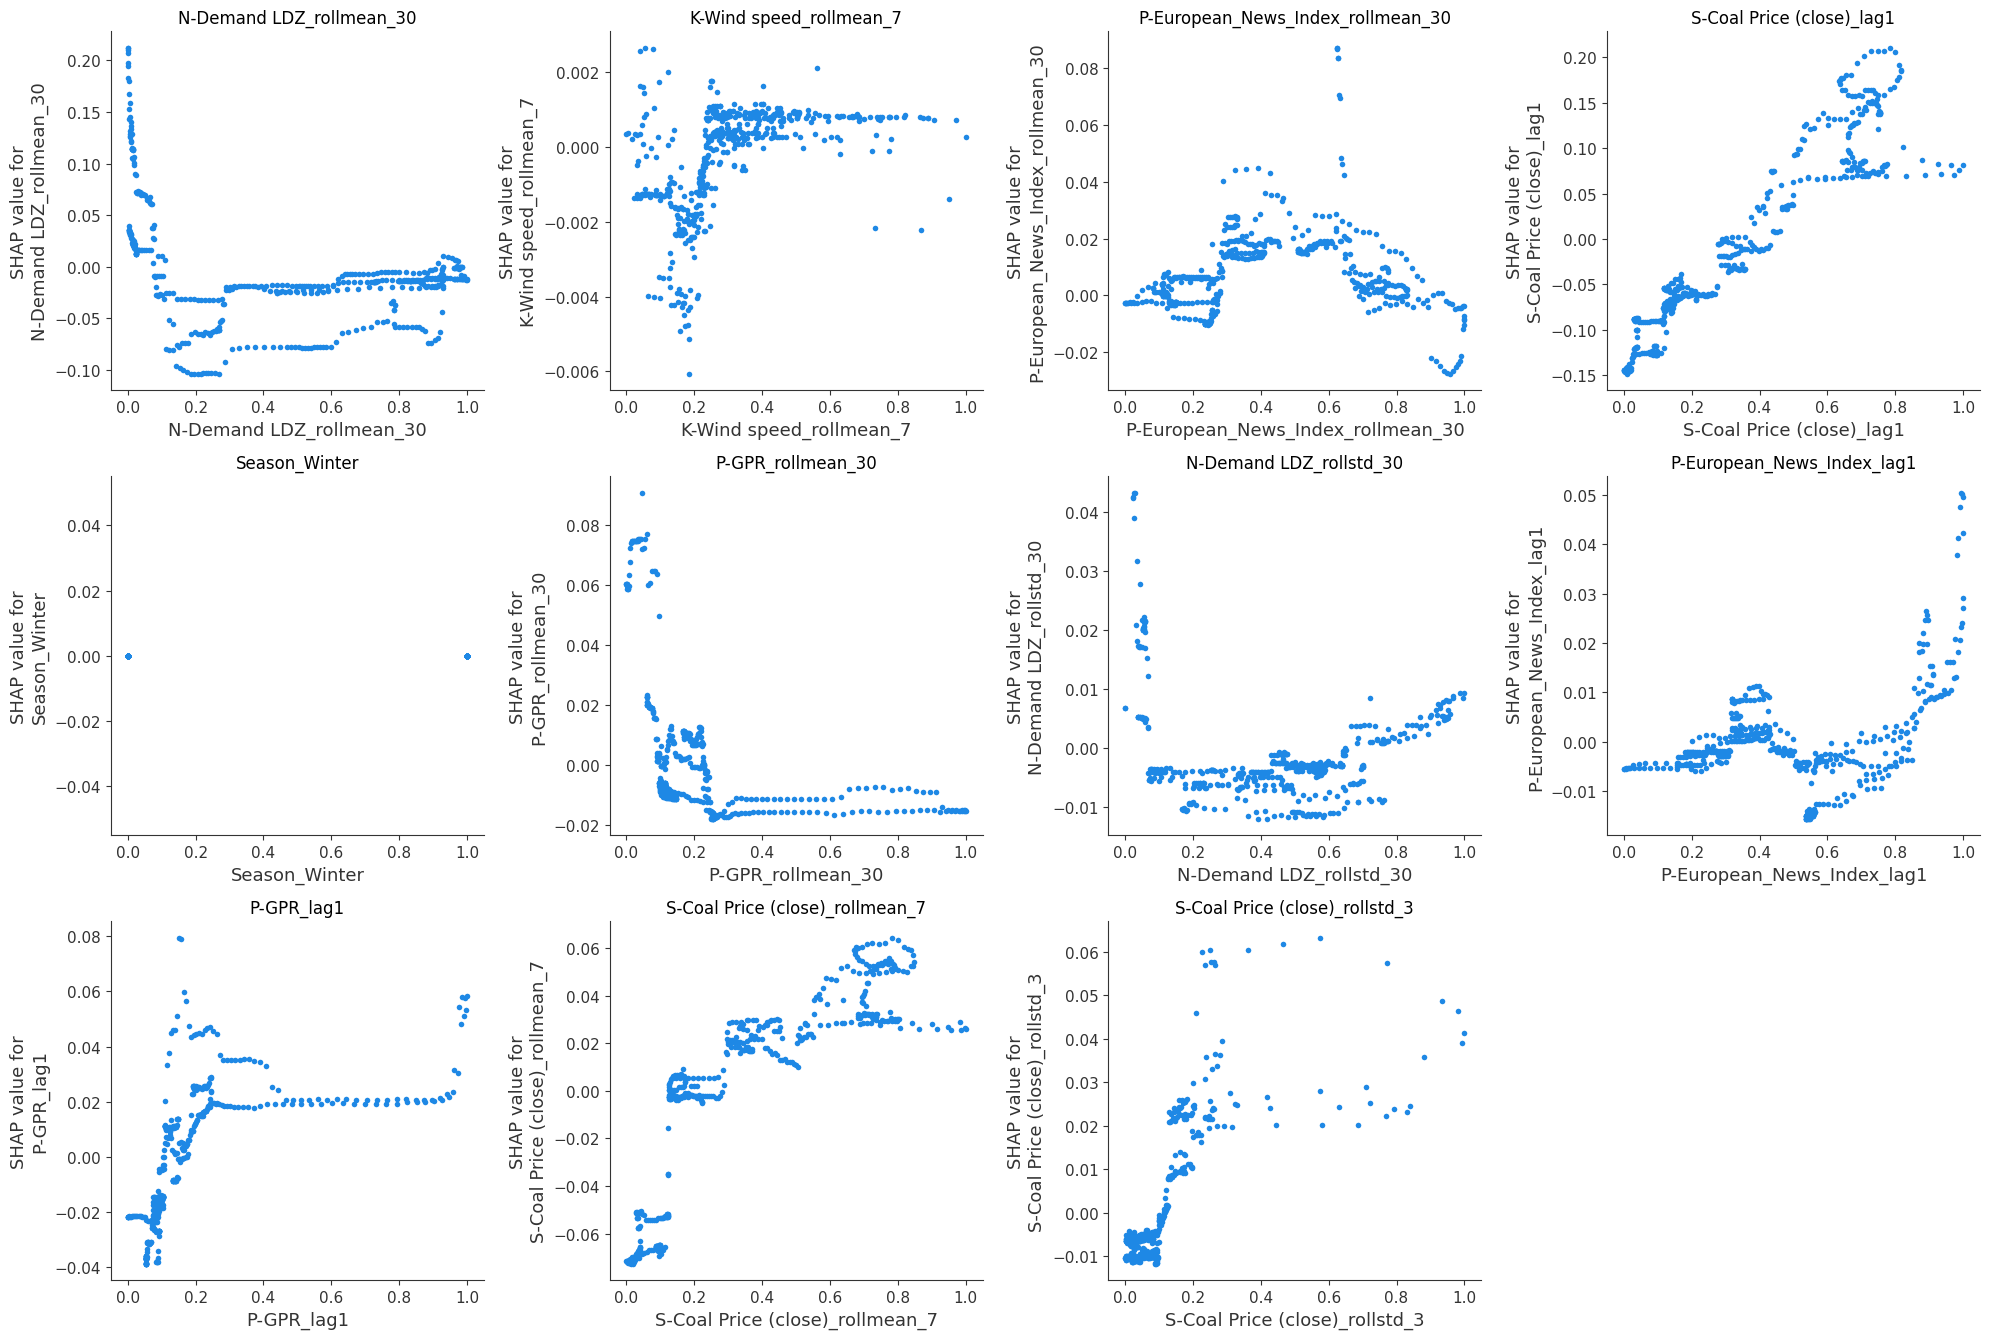

In [37]:
#Dependence Plots für alle Features (ohne Interaktion)
n_feat = len(X_train_sel.columns)

# Grid für alle Dependence-Plots vorbereiten (z. B. 3x3, 4x4 etc.)
n_cols = int(np.ceil(np.sqrt(n_feat)))
n_rows = int(np.ceil(n_feat / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

# Für jedes Feature einen Dependence-Plot zeichnen (ohne Interaktion)
for i, feat in enumerate(X_train_sel.columns):
    shap.dependence_plot(
        feat,
        shap_values_train,
        X_train_sel,
        interaction_index=None,
        show=False,
        ax=axes[i]
    )
    axes[i].set_title(feat)

# Überzählige Achsen entfernen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


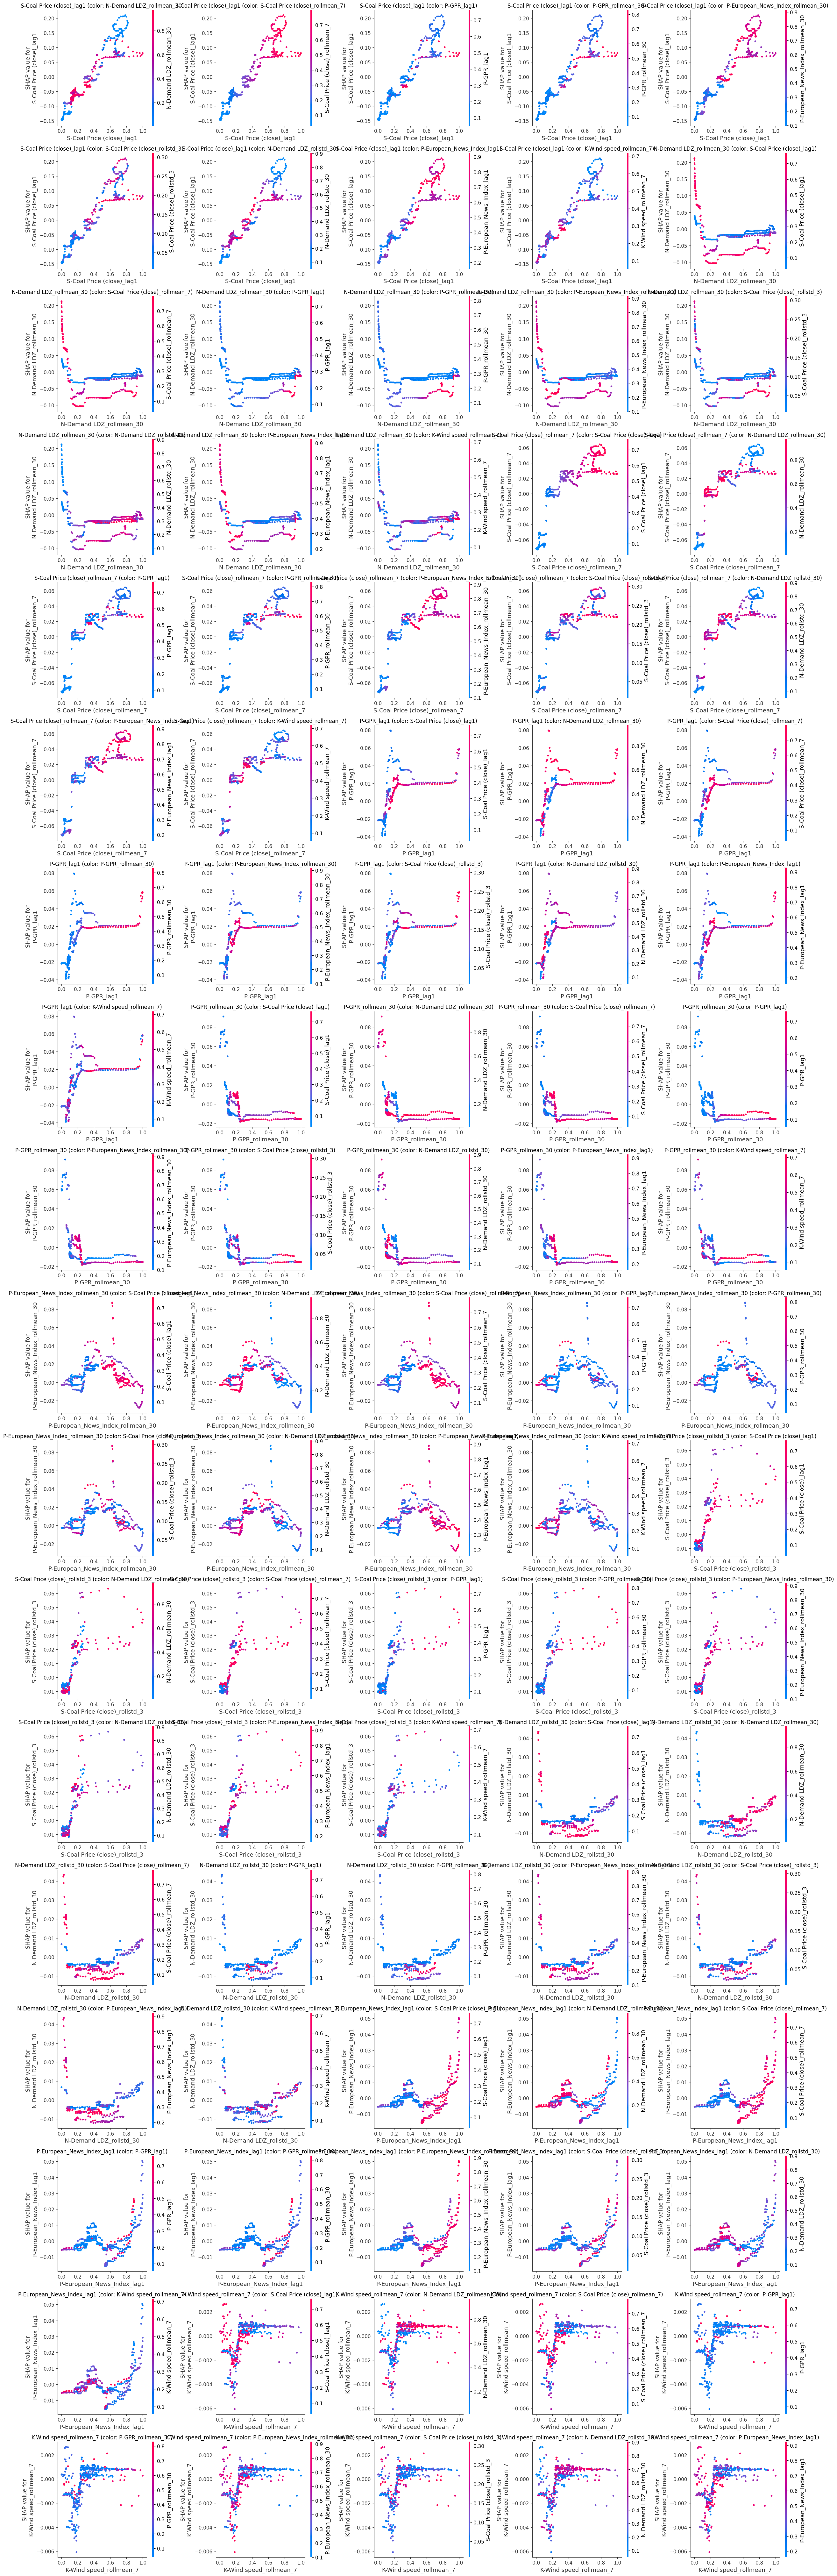

In [38]:


# Top 10 wichtigste Features nach SHAP-Wert
n_feat = 10
top_inds = np.argsort(-np.sum(np.abs(shap_values_train), axis=0))[:n_feat]
cols = X_train_sel.columns[top_inds]

# Alle gerichteten Kombinationen (i ≠ j)
interactions = [(cols[i], cols[j]) for i in range(n_feat) for j in range(n_feat) if i != j]

n_plots = len(interactions)  # = 90 bei 10 Features
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
axes = axes.flatten()

for idx, (f1, f2) in enumerate(interactions):
    shap.dependence_plot(
        f1,
        shap_values_train,
        X_train_sel,
        interaction_index=f2,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"{f1} (color: {f2})")

# Leere Achsen entfernen
for i in range(len(interactions), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### Interaction values

In [39]:
# SHAP Interaction Values
shap_interaction_values = explainer.shap_interaction_values(X_train_sel)

In [ ]:
interaction_matrix = np.abs(shap_interaction_values).mean(axis=0)
interaction_df = pd.DataFrame(interaction_matrix, index=X_train_sel.columns, columns=X_train_sel.columns)
print(interaction_df.round(4))


                                   S-Gas DA D  N-Demand LDZ_rollmean_30  \
S-Gas DA D                             0.1303                    0.0039   
N-Demand LDZ_rollmean_30               0.0039                    0.0113   
K-Wind speed_rollmean_7                0.0004                    0.0000   
P-European_News_Index_rollmean_30      0.0035                    0.0022   
S-Coal Price (close)_lag1              0.0002                    0.0058   
Season_Winter                          0.0000                    0.0000   
P-GPR_rollmean_30                      0.0002                    0.0000   
N-Demand LDZ_rollstd_30                0.0021                    0.0000   
P-European_News_Index_lag1             0.0002                    0.0005   
P-GPR_lag1                             0.0005                    0.0000   
S-Coal Price (close)_rollmean_7        0.0002                    0.0002   
S-Coal Price (close)_rollstd_3         0.0002                    0.0000   

                        

<Figure size 640x480 with 0 Axes>

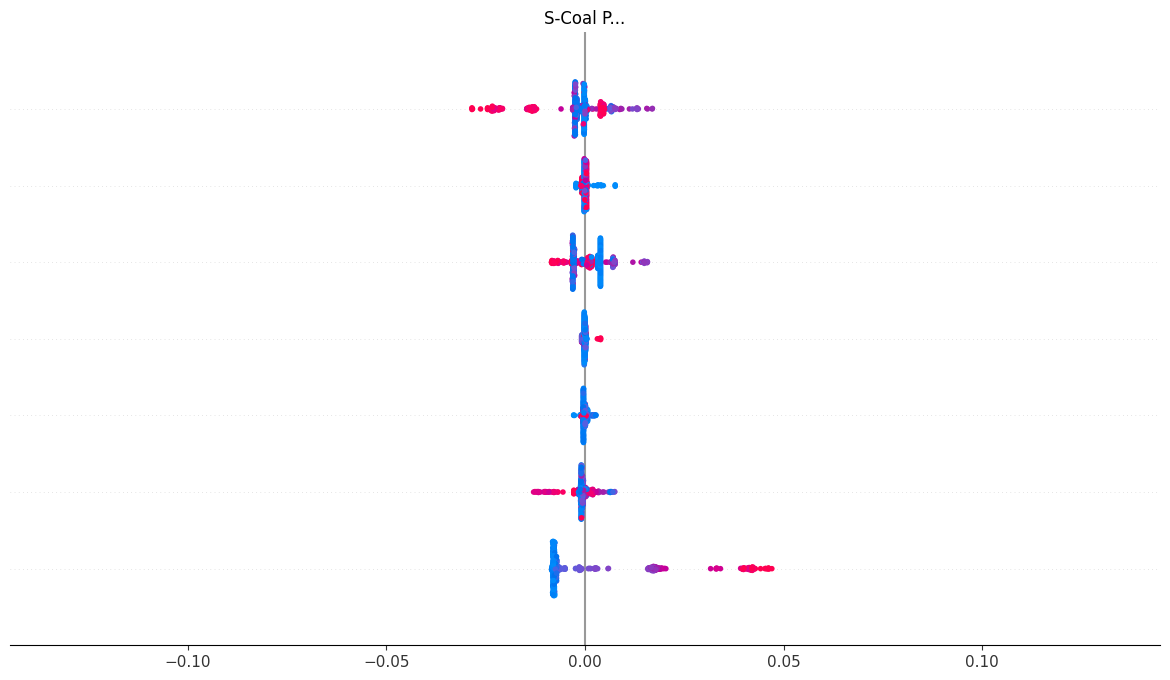

In [40]:
#Summary Plot dependencies
shap.summary_plot(shap_interaction_values, X_train_sel)




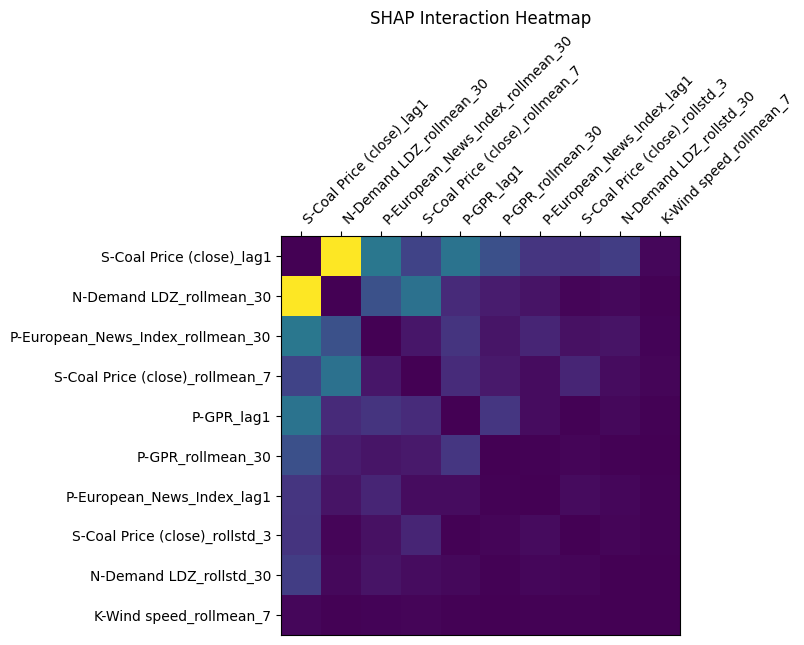

In [41]:
# Matrix der stärksten Interaktionen visualisieren
n_feat = 10
tmp = np.abs(shap_interaction_values).sum(0)
np.fill_diagonal(tmp, 0)  # Selbstinteraktionen auf 0 setzen

inds = np.argsort(-tmp.sum(0))[:n_feat]
tmp2 = tmp[inds, :][:, inds]

plt.figure(figsize=(8, 8))
plt.imshow(tmp2, cmap='viridis')
plt.xticks(range(tmp2.shape[0]), X_train_sel.columns[inds], rotation=45, ha="left")
plt.yticks(range(tmp2.shape[0]), X_train_sel.columns[inds], rotation=0)
plt.gca().xaxis.tick_top()
plt.title("SHAP Interaction Heatmap")
plt.tight_layout()
plt.show()

### Beispiele MA

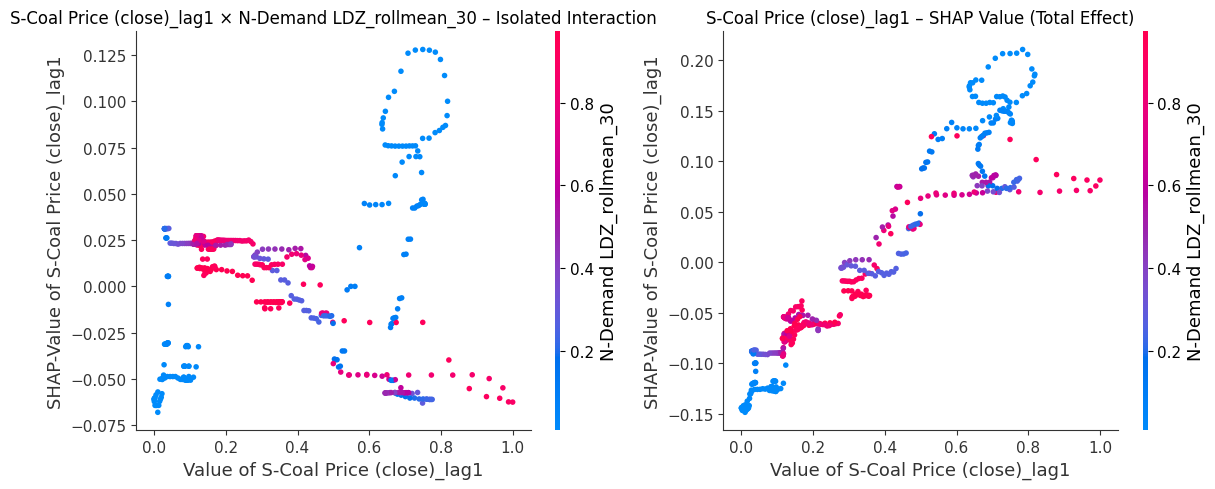

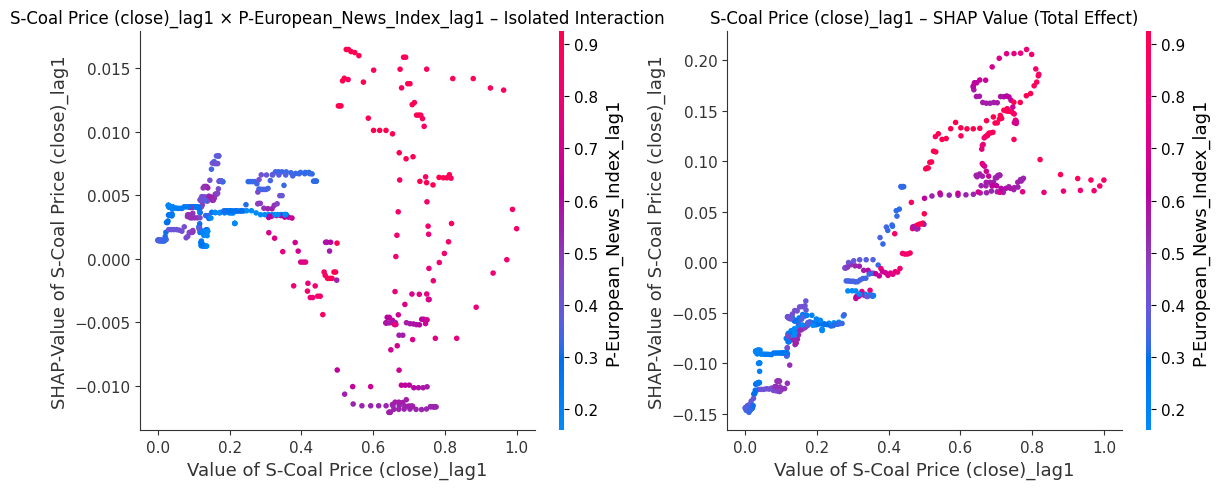

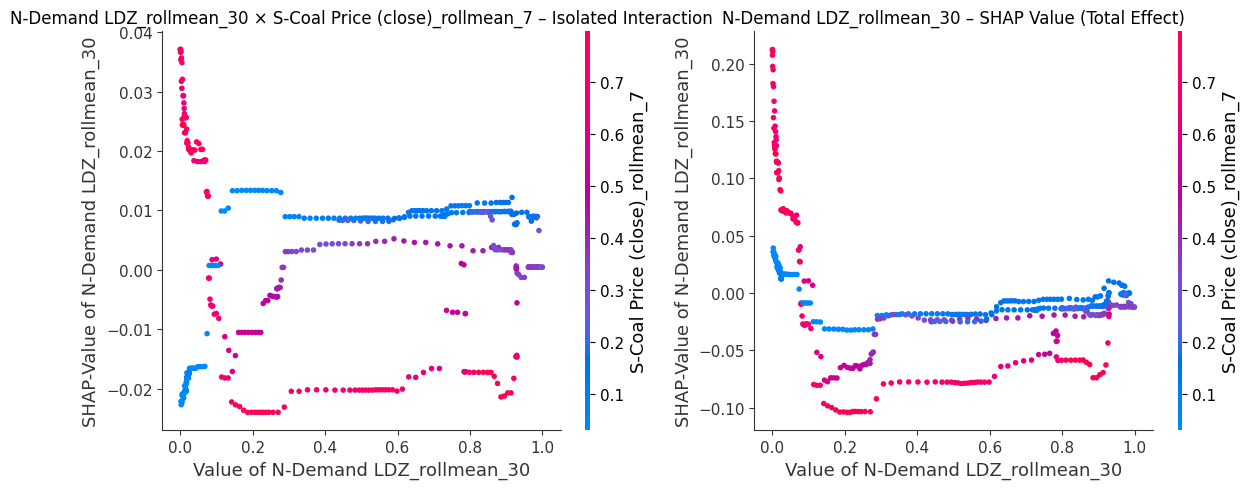

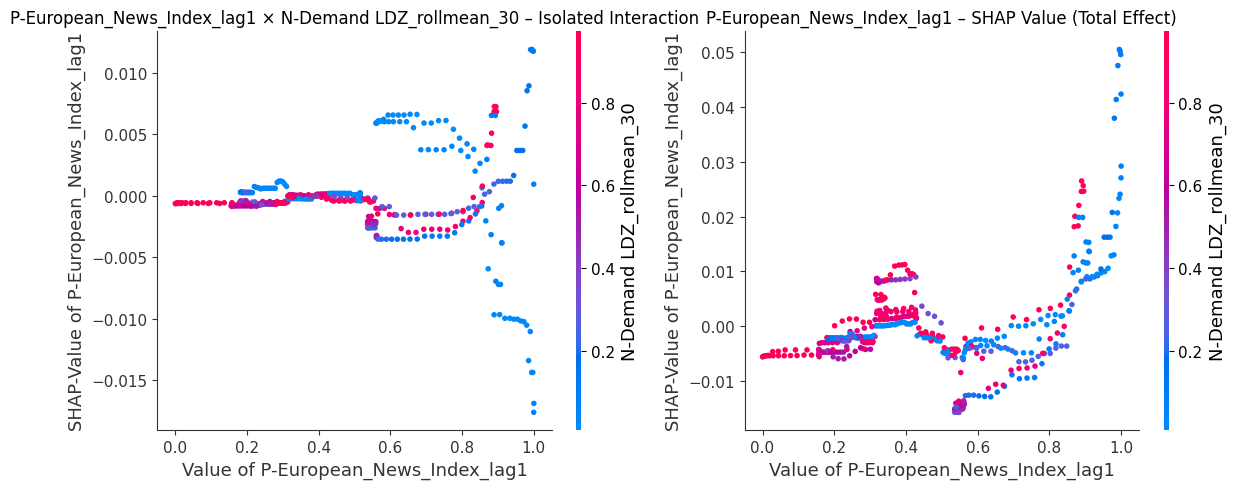

ValueError: 'S-Gas DA D' is not in list

In [42]:

# Spaltenindex-Zuordnung sichern
feature_names = X_train_sel.columns.tolist()

# Interaktionen (angepasst: korrekte Bezeichner!)
interaction_pairs = [
    ("S-Coal Price (close)_lag1", "N-Demand LDZ_rollmean_30"),
    ("S-Coal Price (close)_lag1", "P-European_News_Index_lag1"),
    ("N-Demand LDZ_rollmean_30", "S-Coal Price (close)_rollmean_7"),
    ("P-European_News_Index_lag1", "N-Demand LDZ_rollmean_30"),
    ("S-Gas DA D", "N-Demand LDZ_rollmean_30")
]

# Plot-Loop
for var1, var2 in interaction_pairs:
    i = feature_names.index(var1)
    j = feature_names.index(var2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Isolierte Interaktion (SHAP(i,j))
    shap.dependence_plot(
        (feature_names[i], feature_names[j]),
        shap_interaction_values,
        X_train_sel,
        ax=axes[0],
        show=False
    )
    axes[0].set_title(f"{var1} × {var2} – Isolated Interaction")
    axes[0].set_xlabel(f"Value of {feature_names[i]}")
    axes[0].set_ylabel(f"SHAP-Value of {feature_names[i]}")

    # Plot 2: Gesamteinfluss mit Interaktion (Total SHAP Value)
    shap.dependence_plot(
        ind=i,
        shap_values=shap_values_train,
        features=X_train_sel,
        feature_names=feature_names,
        interaction_index=j,
        ax=axes[1],
        show=False
    )
    axes[1].set_title(f"{var1} – SHAP Value (Total Effect)")
    axes[1].set_xlabel(f"Value of {feature_names[i]}")
    axes[1].set_ylabel(f"SHAP-Value of {feature_names[i]}")

    plt.tight_layout()
    plt.show()


### test vs train shap values

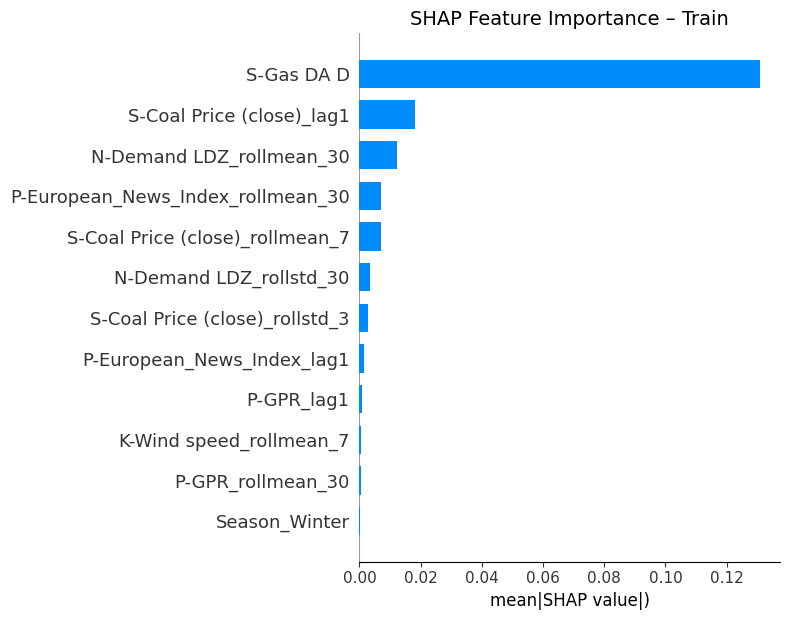

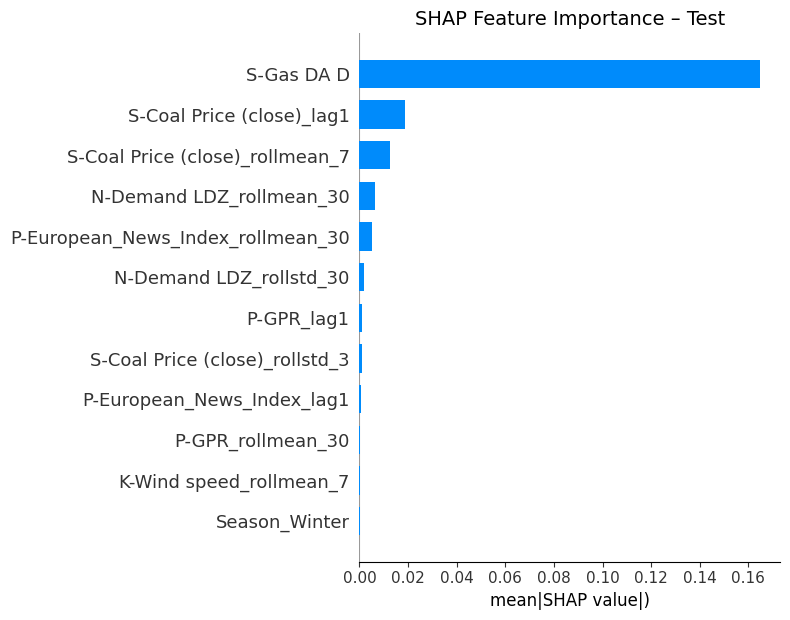

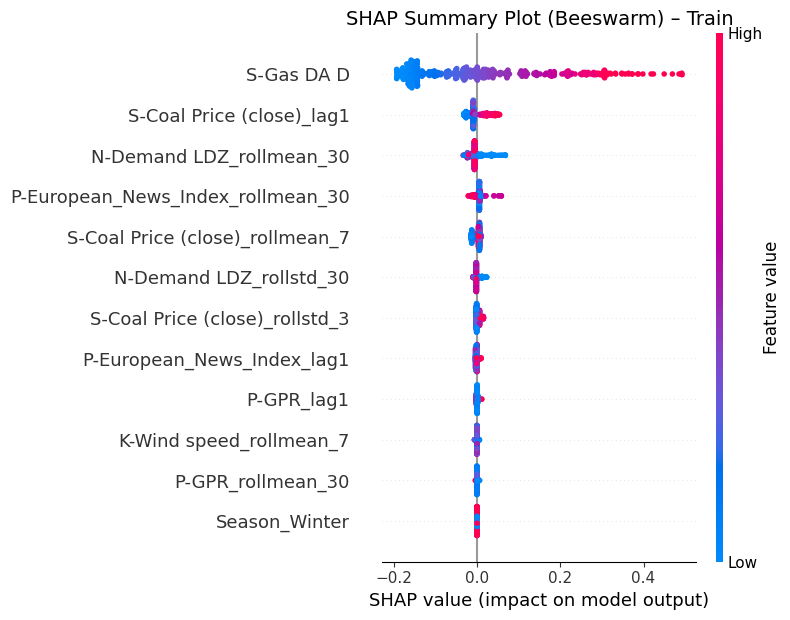

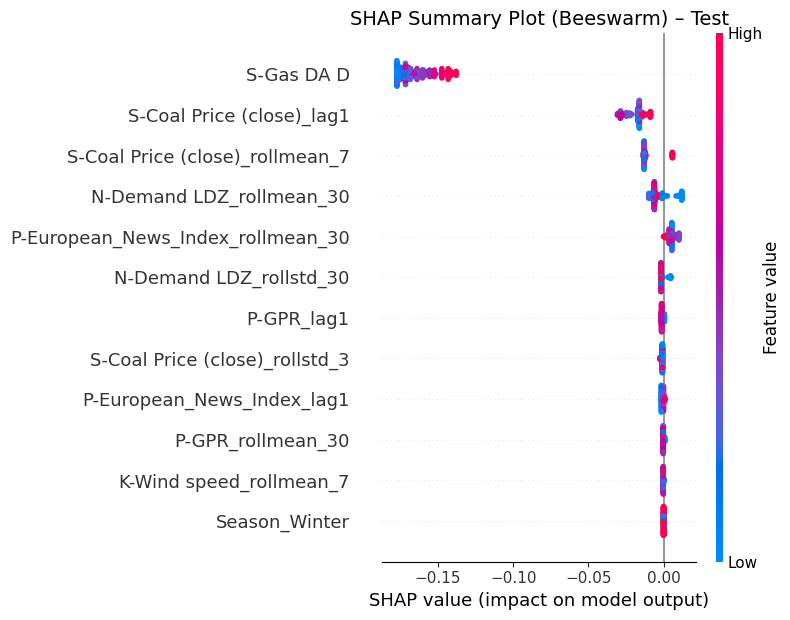

In [40]:
### Vergleich der SHAP-Werte zwischen Training und Test
shap_values_train = explainer.shap_values(X_train_sel)
shap_values_test = explainer.shap_values(X_test_sel)


# SHAP Barplot – Train
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_train, X_train_sel, plot_type="bar", show=False)
plt.xlabel("mean|SHAP value|)", fontsize=12)
plt.title("SHAP Feature Importance – Train", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Barplot – Test
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_test, X_test_sel, plot_type="bar", show=False)#
plt.xlabel("mean|SHAP value|)", fontsize=12)
plt.title("SHAP Feature Importance – Test", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Beeswarm – Train
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_train, X_train_sel, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Beeswarm) – Train", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Beeswarm – Test
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_test, X_test_sel, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (Beeswarm) – Test", fontsize=14)
plt.tight_layout()
plt.show()
